We're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

To do, we'll leverage the pubically available [Medical Cost dataset](https://www.kaggle.com/mirichoi0218/insurance) available from Kaggle and [hosted on GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).



In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs).

To do so, we'll use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method in pandas.

It converts categorical variables (like the `sex`, `smoker` and `region` columns) into numerical variables using one-hot encoding.

In [4]:
# Turn all categories into numbers
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [5]:
# Create X & y values
y = insurance_one_hot["charges"]
X= insurance_one_hot.drop("charges", axis=1)


In [6]:
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


In [7]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

In [8]:
# Set random seed
tf.random.set_seed(42)

# Create a new model (same as model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=['mae'])

# Fit the model
insurance_model.fit(X_train, y_train, epochs=100, verbose=0)

In [9]:
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 4ms/step - loss: 8646.7793 - mae: 8646.7793


[8646.779296875, 8646.779296875]

Our model didn't perform very well, let's try a bigger model.

We'll try 3 things:
- Increasing the number of layers (2 -> 3).
- Increasing the number of units in each layer (except for the output layer).
- Changing the optimizer (from SGD to Adam).

Everything else will stay the same.

In [10]:
# Set random seed
tf.random.set_seed(42)

# Add an extra layer and increase number of units
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # 100 units
  tf.keras.layers.Dense(10), # 10 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])

# Compile the model
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam works better than SGD 
                          metrics=['mae'])

# Fit the model and save the history (we can plot this)
history = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [11]:
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 4640.5298 - mae: 4640.5298


[4640.52978515625, 4640.52978515625]

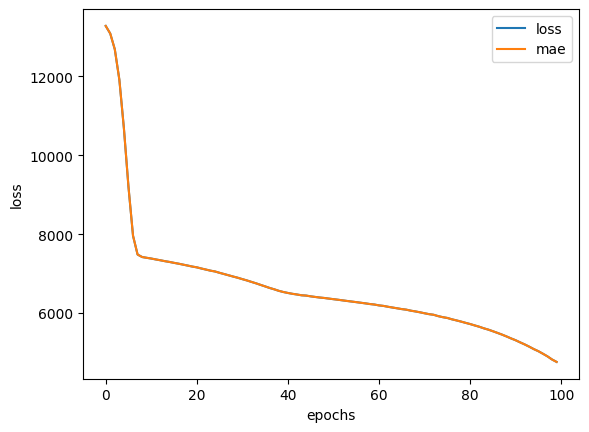

In [12]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [74]:

from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

insurance_model_2.fit(X_train, y_train, callbacks=[lr_sched])

34/34 [==============================] - 0s 2ms/step - loss: 4694.1147 - mae: 4694.1147 - lr: 1.0000e-04


From this, it looks like our model's loss (and MAE) were both still decreasing (in our case, MAE and loss are the same, hence the lines in the plot overlap eachother).

What this tells us is the loss might go down if we try training it for longer.

> **Question:** How long should you train for? 

> It depends on what problem you're working on. Sometimes training won't take very long, other times it'll take longer than you expect. A common method is to set your model training for a very long time (e.g. 1000's of epochs) but set it up with an [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) so it stops automatically when it stops improving. We'll see this in another module.

Let's train the same model as above for a little longer. We can do this but calling fit on it again.

## Task

**Try different methods to improve this model's performance**

In [116]:
# Set random seed
tf.random.set_seed(42)


# Add an extra layer and increase number of units
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100,activation='relu'),# 100 units
  tf.keras.layers.Dense(80),  # 60 units
  tf.keras.layers.Dense(60),# 30 units
  tf.keras.layers.Dense(40),  
  tf.keras.layers.Dense(20), # 10 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])



# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Nadam(learning_rate=0.01), # Adam works better than SGD 
                          metrics=['mae'])

# Fit the model and save the history (we can plot this)
history = insurance_model_3.fit(X_train, y_train, epochs=120, verbose=0)

In [117]:
insurance_model_3.evaluate(X_test, y_test)
y_preds = insurance_model_3.predict(X_test)

9/9 [==============================] - 0s 2ms/step


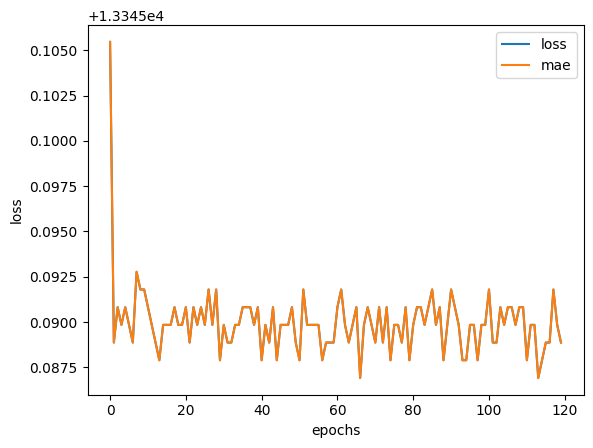

In [118]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

In [82]:
np.mean(y_preds.reshape(268,) - y_test)

-236.06517277231146

9/9 [==============================] - 0s 2ms/step


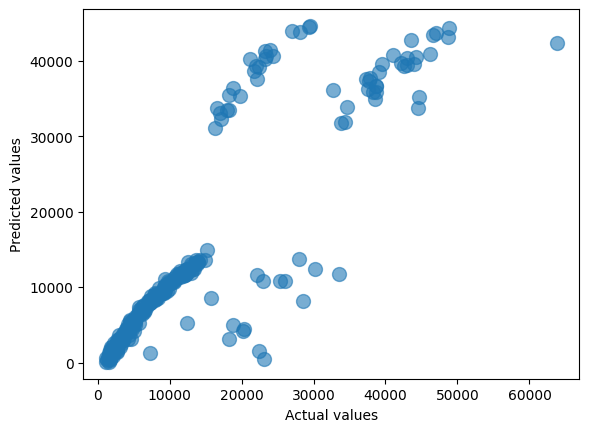

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions using your deep learning model
predicted = insurance_model_3.predict(X_test)

# Get the actual values of the test set
actual = y_test

# Create a scatter plot of the predicted values against the actual values
plt.scatter(actual, predicted.reshape(268,), alpha=0.6, label='Actual vs Predicted', s=100, marker='o')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()





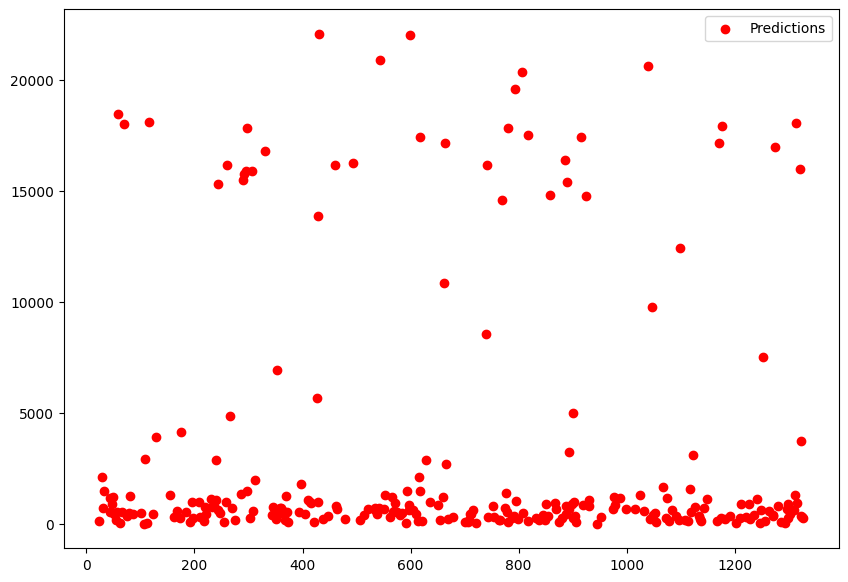

In [40]:
plot_predictions()